In [ ]:
%matplotlib inline

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.data.path.append("/Users/Michel_home/Documents/Projects/PythonPlay/nltk_data")
import pandas as pd
import pickle as pkl
import pymysql as mdb
import random
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split

import re
import time

In [ ]:
import datetime
from pandas.tools.plotting import scatter_matrix

## ******************content engineering********************

In [ ]:
techDF = pd.read_json("Data/techno_content.json")

In [ ]:
techDF.sort("title")

In [ ]:
techDF.drop_duplicates(inplace=True)#subset = "title")
#techDF.shape

In [ ]:
t = [d for d in techDF.descr if len(d)>12]
len(t)

In [ ]:
tech_samp = techDF.copy()

In [ ]:
tech_samp.shape

In [ ]:
def list_to_string(lista):
    if isinstance(lista, list) and lista:
        return lista[0]
    else:
        return lista if lista else ""

    
def descrlist_to_fulltext(string):
    #tokenize text
    pattern = re.compile('[^a-zA-Z]+')
    fulltext = pattern.sub(' ', ' '.join(string))
    return fulltext

def urlExtract(url_string = ""):
    pat = re.compile("\/id\/([\w-]+)\/")
    url = re.findall(pat, url_string)
    if url:
        return url[0]
    else:
    1    return "Error 404: Page not found! The url provided is not of proper format"



def Nsteps_to_N(step_list):
    if isinstance(step_list, list) and step_list:
        num = re.findall('\d+', step_list[0])[0]
        return int(num)
    else:
        return 0

def Nitem_to_N(alist):
    return len(alist)
   
def meta_to_category(script):
    string = script[0]
    categ = re.findall('ibleCategory: "([\w\-\/]+)"', string)
    if not categ:
        categ = [""]
    url = re.findall('ibleUrl: "([\w\-\/]+)"', string)
    if not url:
        url = [""]
    channel = re.findall('ibleChannel: "([\w\-\/]+)"', string)
    if not channel:
        channel = [""]
        
    return pd.Series( {"url" : url[0], "category": categ[0], "channel":channel[0]})

#not robust against unusual format
def meta_to_views(script):
    fav = script[0]
    favorites = re.findall('favorites:(\d+)', fav)
    vw = script[1]
    views = re.findall('views:(\d+)', vw)
    return pd.Series( {"views" : views[0], "favorites": favorites[0]})


def date_to_datetime(datestring):
    datestring = datestring[0]
    delta = datetime.datetime.now() - datetime.datetime.strptime(datestring, "%Y-%m-%d %H:%M:%S.%f")
    return np.round(delta.total_seconds()/86400)
    

In [ ]:
tech_samp.columns

In [ ]:
#WORKS
s = slice(20389, 20400)
testurl = [urlExtract(u) for u in df.loc[s, 'projectID']]
testurl

In [ ]:
#FEATURE ENGINEEEEERING ###########
df = tech_samp[["projectID"]]

df.loc[:, "Nimg"] = tech_samp["Nimages"].apply(Nitem_to_N)
df.loc[:, "Nlnk"] = tech_samp["Nlinks"].apply(Nitem_to_N)
df.loc[:, "Nstp"] = tech_samp["Nsteps"].apply(Nsteps_to_N)
df.loc[:,"Nvid"] = tech_samp["Nvideos"].apply(Nitem_to_N)
#df.loc[:,"Ncmmt"] = tech_samp["comments"].apply(Nitem_to_N)
df.loc[:, "Nxtra"] = tech_samp["contentExtra"].apply(Nitem_to_N)
#df.loc[:,"author"] = tech_samp["author"].apply(list_to_string)
df.loc[:, "award"] = tech_samp["award"].apply(list_to_string)
df.loc[:, "scripts"] = tech_samp["scripts"].apply(Nitem_to_N)
df.loc[:, "keywords"] = tech_samp["keywords"].apply(list_to_string)
df.loc[:, "title"] = tech_samp["title"].apply(list_to_string)
#df.loc[:,"comments"] = tech_samp["comments"].apply(list_to_string)
df.loc[:, "fulltext"] = tech_samp["descr"].apply(descrlist_to_fulltext)
df.loc[:, "Ndscr"] = df["fulltext"].apply(len)
df.loc[:, "daysold"] = tech_samp["date"].apply(date_to_datetime)
df.loc[:, "tags"] = tech_samp["tags"].apply(list_to_string)

# the "category" field actually has information on Channel, Category, URL
catstring = tech_samp["category"].apply(meta_to_category)
df.loc[:,"category"] = catstring["category"]
df.loc[:,"channel"] = catstring["channel"]
df.loc[:,"url"] = catstring["url"]

# views and favorites stored in list in original column "views"
#viewstring = tech_samp["views"].apply(meta_to_views) 
#df.loc[:,"favorites"] = viewstring["favorites"]
#df.loc[:,"views"] = viewstring["views"]

df.convert_objects(convert_numeric=True)
df.shape

In [ ]:
df = df[(df.Nstp >1) & (df.Ndscr >40) & (df.url != '') & (df.Nimg > 3) & (df.Nimg < 300)]

df.loc[:,"dscrPerImg"] = df["Ndscr"]/df["Nimg"]
df.loc[:,"dscrPerStp"] = df["Ndscr"]/df["Nstp"]
df.loc[:,"logNdscr"] = df["Ndscr"].apply(np.log)
df.loc[:,"logImg"] = df["Nimg"].apply(np.log)

df = df[(df.dscrPerStp < 6000) & (df.dscrPerImg < 4500)]
df.drop_duplicates(subset = "url", inplace = True)

In [ ]:
df[df.dscrPerImg > 4000].url

In [ ]:
print df.shape
df.columns

In [ ]:
# NO URL longer than 60
df[df.url.apply(len)>60].url

In [ ]:
df[df.logNdscr != 0].logNdscr.tail()

# Start visualizing raw data


In [ ]:
df2 = df[df.Nimg > 3]
df2 = df2.loc[:,[ "Nstp","Ndscr", "Nimg", "channel"]]
cor = df.corr()#[["Ndscr", "Nimg","Nstp"]].corr()
sns.heatmap(cor, square=True)

In [ ]:
g = sns.PairGrid(df[["logNdscr","dscrPerImg","dscrPerStp"]], size = 6 )
g.map_diag(sns.kdeplot, lw=3)
g.map_lower(sns.kdeplot, cmap="Blues_d")

In [ ]:
df1 = df[df.channel == "arduino"]
df3 = df[df.channel != "arduino"]

randrows = random.sample(range(len(df)),2000)
colors = df.loc[randrows,"channel"].map(lambda x: "#0392cf" if x=="arduino" else "#7bc043")
colors[-12:]

In [ ]:
#This shows there is no easy answer like, "all arduino" projects always have more lengths then other channels
scatter_matrix(df.loc[randrows,["logNdscr","logImg","Nstp"]], color = colors, figsize=(12,9),alpha = 0.5,diagonal='kde')

In [ ]:
df.Nstp.describe()

In [ ]:
feat_corr = df[df.Nlnk==0].corr()
sns.heatmap(feat_corr, square=True)

In [ ]:
df_temp = df[df["Nimg"]>100 and df["Ndscr"]<2]
scatter_matrix(df_temp[["Nimg", "Ndscr"]],figsize=(12,9),alpha = 0.5,diagonal='kde');

In [ ]:
#check if my Nitem_ works for descriptions
print df.loc[65]

In [ ]:
df_temp = df[df["Ndscr"]<2]
df_temp.head(2)

In [ ]:
df[df["Nxtra"]>0].Nxtra.hist(bins=50)

In [ ]:
plots = df[df["channel"].isin(["Arduino","cnc"])].groupby("channel").hist(bins = 50)
len(plots)

In [ ]:
df[df.Nimg<100]["Nimg"].hist(bins = 50)


In [ ]:
datadf = df.loc[:1000,["Ndscr","Nimg","Nstp"]]

In [ ]:
#datadf = df.loc[:1000,"Ndscr","Nimg","Nstp"]
dfnorm = scale(df)

n_clusters = 2
np.random.seed(4)

n_samples, n_features = datadf.shape
#n_digits = len(np.unique(labels))
sample_size = 300

model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=20)
train = model.fit(dfnorm)

In [ ]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=20), name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_clusters, n_init=20), name="random", data=data)

In [ ]:
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=2).fit(dfnorm)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_clusters, n_init=10),name="PCA-based", data=data)

In [ ]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=20)
kmeans.fit(reduced_data)
bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=20), name="stuff", data=reduced_data)
print(79 * '_')

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

In [ ]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() + 0, reduced_data[:, 0].max() - 0
y_min, y_max = reduced_data[:, 1].min() + 0, reduced_data[:, 1].max() - 0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
cluster_id= kmeans.labels_
#print type(cluster_id)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
y = df["views"].values

df["descr"] = tech_samp["descr"].apply(list_to_string)
df[""] = tech_samp["date"].apply()****
df[""] = tech_samp["relatedURL"].apply()
df[""] = tech_samp["tags"].apply()

# ####### Label engineering ########

In [ ]:
print df.dtypes

In [ ]:
random.sample(range(len(df)), 300)

In [ ]:
row = 20043
print df.loc[row].projectID

In [ ]:
df.loc[row,"complex"]=1

In [ ]:
df.to_pickle("techno_features.pickle")

In [ ]:
df[np.isnan(df.dscrPerStp)].views

In [ ]:
data= df[df.complex>=0].copy()
data.loc[:,"dscrPerStp"] = data["Ndscr"]/data["Nstp"]
data

In [ ]:
df["complex"]

In [ ]:
#make vector of features
dataRaw = df.loc[df["complex"] > 0,["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp", "scripts", "dscrPerImg"]]

dataRaw.fillna(value=0)
print dataRaw.head(1)
label = df.loc[df["complex"] > 0,"complex"]
data = scale(dataRaw)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size = 0.3)

In [ ]:
linmodel = SVR(kernel='linear')
linSVR = model.fit(X_train,Y_train)
rbfmodel = SVR(kernel='rbf')
rbfSVR = model.fit(X_train,Y_train)

In [ ]:
y_predlin = linSVR.predict(X_test)
y_predrbf = rbfSVR.predict(X_test)

In [ ]:
plt.scatter(Y_test,y_predrbf)
plt.xlabel("True complexity")
plt.ylabel("Estimated complexity")
plt.grid(b=False)

In [ ]:
raw = df.loc[:,["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp","Ncmmt", "scripts", "dscrPerImg"]].values
raw

In [ ]:
ALLdata = scale(raw)
df.loc[:,"complexEst"] = rbfSVR.predict(ALLdata)

In [ ]:
scatter_matrix(df.loc[:5000,["complexEst","Nstp"]])

In [ ]:
def find_project(difficulty, ):

In [ ]:
#dont use this line as is....
df.to_pickle("techno_content-with_c.pickle")

In [ ]:
#df.to_pickle("Data/techno_features.pickle")
df.shape

In [ ]:
dataDF = pd.read_pickle('Data/techno_features.pickle')

In [ ]:
dataDF2 = pd.read_pickle('Data/techno_content-with_complexity.pickle')

In [ ]:
dataDF = dataDF.merge(dataDF2.loc[:,["url","complex"]], on="url")
dataDF.shape

In [ ]:
dataDF = df.copy()

In [ ]:
#make vector of features
dataRaw = dataDF.loc[dataDF["complex"] > 0, ["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp", "scripts", "dscrPerImg"]]
dataRaw.fillna(value=0, inplace = True)

label = dataDF.loc[dataDF["complex"] > 0, "complex"]
data = scale(dataRaw)

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(data, label, test_size = 0.3)

In [ ]:
linmodel = SVR(kernel='linear')
linSVR = linmodel.fit(X_train,Y_train)
rbfmodel = SVR(kernel='rbf')
rbfSVR = rbfmodel.fit(X_train,Y_train)

In [ ]:
ALLdata = dataDF.loc[:, ["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp", "scripts", "dscrPerImg"]]
dataDF.loc[:, "complexEstimate"] = rbfSVR.predict(scale(ALLdata))

In [ ]:
dataDF.describe()

In [ ]:
f = open('rbfmodel.pickle','wb')
s = pkl.dump(rbfmodel,f)
f.close()
#clf2 = pickle.load(s)
# predict on ["logNdscr","logImg","Nstp","Nlnk", "Nstp", "Nvid","dscrPerStp", "scripts", "dscrPerImg"]

In [ ]:
df.to_pickle('techno_df_w_estimates.pickle')

In [ ]:
con = mdb.connect(user="root", host="localhost", db="instructables",  charset='utf8', unix_socket='/tmp/mysql.sock', port='3307')

In [ ]:
testDB = dataDF.loc[:, ["Ndscr", "Nimg", "Nlnk","Nstp", "Nxtra","dscrPerImg", "dscrPerStp", "logNdscr", "url", "logImg", "channel", "keywords", "complexEstimate"]]
testDB.shape

In [ ]:
testDB.to_sql(con=con, name='technoFeatures', if_exists='replace', flavor='mysql')
con.close()

In [ ]:
dataDF.columns

In [ ]:
dataDF.to_pickle('techno_data_with_estimates.pickle')

In [ ]:
pd.Dataframe()

In [ ]:
dataDF = pd.read_pickle("techno_data_with_estimates.pickle")

In [ ]:
textList = [tex for tex in dataDF.fulltext.values]
textList[:2]

In [ ]:
#################### TOKENIZATION ##################

In [70]:
import nltk.corpus
from nltk.corpus import stopwords
nltk.tag._POS_TAGGER


'taggers/maxent_treebank_pos_tagger/english.pickle'

In [103]:
corpa = ' '.join(textList[:50])
tokens = nltk.word_tokenize(corpa.lower())
pos = nltk.pos_tag(tokens)

In [104]:
#verbs = [v[0] for v in pos if v[1] in ['VB','VBN','VBG','VBP'] ]
#nouns = [v[0] for v in pos if v[1] in ['NN', 'NNP', 'NNPS', 'NNS'] ]
corpus = [v[0] for v in pos if (v[1] in ['NN', 'NNP', 'NNPS', 'NNS','VB','VBN','VBG','VBP']) and (v[0] not in mystopwords)]
len(corpus)

26976

In [63]:
tags = [v for w,v in pos]
unique = []
for tag in tags:
    if tag not in unique:
        unique.append(tag)
print unique

['JJS', 'IN', 'PRP', 'VBP', 'RB', 'VB', 'NN', 'DT', 'VBN', 'WDT', 'MD', 'WRB', 'CC', 'JJ', 'VBZ', 'VBG', 'TO', 'NNS', 'NNP', 'RP', 'PRP$', 'VBD', 'JJR', 'NNPS', 'RBR', 'CD', 'EX', 'RBS', 'WP', 'WP$', 'PDT', 'FW']


In [64]:
for v in pos:
    if v[1] == 'FW':
        print v 

(u'De', 'FW')
(u'de', 'FW')


In [113]:
mystopwords =  stopwords.words("english")
print len(mystopwords)
extrawords = ["make","need","using","get", "see","x", "m", "v","want", "d", "www", "org"]
for xtra in extrawords:
    mystopwords.append(xtra)
len(mystopwords)

127


139

# stem and lemma

In [108]:
from nltk.stem.snowball import SnowballStemmer

In [122]:
stemmer = SnowballStemmer("english")

In [123]:
test = [stemmer.stem(word) for word in textList[5].split()]
print textList[5].split()[:15]
test[:15]

[u'In', u'this', u'project', u'we', u'will', u'be', u'making', u'a', u'wireless', u'side', u'lamp', u'that', u'can', u'be', u'controlled']


[u'in',
 u'this',
 u'project',
 u'we',
 u'will',
 u'be',
 u'make',
 u'a',
 u'wireless',
 u'side',
 u'lamp',
 u'that',
 u'can',
 u'be',
 u'control']

In [231]:
# for every text, process them with stop words
stemmer = SnowballStemmer("english")
newdocumentF =[] 
for document in textList[12000:13500]:
    tokens = nltk.word_tokenize(document.lower())
    pos = nltk.pos_tag(tokens)
    relevant = [v[0] for v in pos if (v[1] in ['NN', 'NNP', 'NNPS', 'NNS','VB','VBN','VBG','VBP']) and (v[0] not in mystopwords)]
    stemmed = [stemmer.stem(word) for word in relevant]
    newdocumentF.append(' '.join(stemmed))

In [232]:
len(newdocumentF)#[7031][:100]
#textList[9999][:200]

1500

In [203]:
newdocumentB[1967][:200]

u'usb hub insid snes cartridg fun project start play retro game snes nes emul pc game nt feel comput screen tv fun extens cabl gamepad lie place usb insid snes cartridg kart everyon eveybodi love game h'

In [233]:
testL = newdocumentsA+newdocumentB+newdocumentC+newdocumentD+newdocumentE+newdocumentF
len(testL)#newdocumentC[999][:100]#textList[7031][:200]

13500

In [215]:
with open("newdocumentABC.pickle", 'wb') as f:
    pkl.dump(testL, f)

In [208]:
# retrieve dumped parsed documents
with open("newdocumentABC.pickle", 'rb') as f:
    testL2 = pkl.load(f)
print len(testL2)
testL2[9999][:100]

10000


u'warm touch screen glove go buy glove acryl spandex note materi work check comment lick lick tip take'

In [125]:
nltk.pos_tag(["having", "munchies", "arduino","the"])

[('having', 'VBG'), ('munchies', 'NNS'), ('arduino', 'RB'), ('the', 'DT')]

In [105]:
corpusFreq = nltk.FreqDist(corpus)
#verbcount = nltk.FreqDist(verbs)
#nounscount = nltk.FreqDist(nouns)

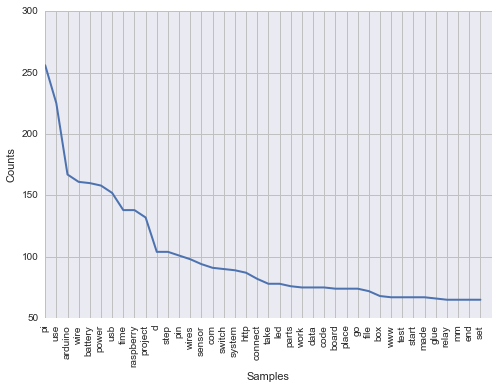

In [106]:
corpusFreq.plot(40)
#verbcount.plot(30, cumulative = False)

In [ ]:
text = nltk.Text(tokens)
freq1 = nltk.FreqDist(ch.lower() for ch in text if ch.isalpha())
freq1.plot(70,cumulative = True)

In [ ]:
raw = " ".join(des2)
tokens = nltk.word_tokenize(raw)
lengths = [(len(fdr),fdr) for fdr in tokens ]
lengths.sort(reverse=True)
lengths

In [ ]:
raw = " ".join(des2)
tokens = nltk.word_tokenize(raw)
regtok = [tok for tok in tokens if len(tok)<16 and tok.isalnum()]
regtok

In [ ]:
text = nltk.pos_tag(tokens)
verbs = [v[0] for v in text if v[1] == "VB"]
verbs = nltk.word_tokenize(" ".join(verbs))

In [ ]:
verbing = re.findall(" (\w+ing) "," ".join(des2))

In [ ]:
sorted([(verbing.count(l),l) for l in verbing], reverse=True)

In [ ]:
verbs = nltk.FreqDist(" ".join(verbs))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [234]:
documents = textList[:10000]
len(documents)

10000

In [235]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
tfidf_matrix.shape

(10000, 103285)

In [236]:
cosARRAY = cosine_similarity(tfidf_matrix[0:34], tfidf_matrix)
cosARRAY 

array([[ 1.        ,  0.3146106 ,  0.41084762, ...,  0.11555132,
         0.28750901,  0.09608209],
       [ 0.3146106 ,  1.        ,  0.20572423, ...,  0.08313831,
         0.19503859,  0.05724038],
       [ 0.41084762,  0.20572423,  1.        , ...,  0.08022494,
         0.17754916,  0.07096804],
       ..., 
       [ 0.11575513,  0.08079367,  0.08349012, ...,  0.03133151,
         0.10339419,  0.02928314],
       [ 0.3328301 ,  0.20203016,  0.20923492, ...,  0.06989738,
         0.17143612,  0.06813452],
       [ 0.43021878,  0.28181834,  0.28673892, ...,  0.15262198,
         0.29829492,  0.1119714 ]])

In [248]:
# INDEX of the most similar projects
s = cosARRAY[7]
indices = sorted(range(len(s)), reverse = True, key=lambda k: s[k])
indices[:10]

[7, 4741, 1509, 3869, 6219, 3562, 4047, 7624, 1399, 5896]

In [250]:
print cosARRAY[7][7]
print cosARRAY[7][4741]

1.0
0.654069978093


In [268]:
for t in dataDF.iloc[[7,4741, 1509, 3869, 6219, 3562]].fulltext:
#for t in dataDF.iloc[[7,4744, 1549, 3849, 6249, 3542]].fulltext:
    print t.count('led ')

2
21
6
16
2
5


In [ ]:
dataDF